<a href="https://colab.research.google.com/github/Mr94t3z/pembelajaran-mesin/blob/master/meeting_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis Case Using Simple RNN, Single LSTM, Bidirectional LSTM, and CNN 

## Dataset Importing

In [4]:
import pandas as pd

## Use this to read data directly from github
train = pd.read_csv('https://raw.githubusercontent.com/Mr94t3z/pembelajaran-mesin/master/datasets/twitter.csv', sep=',')

## Data Understanding

In [5]:
train.head(10)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


In [6]:
len(train)

27481

In [7]:
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [8]:
#How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,textID,text,selected_text
sentiment,,,
negative,7781,7781,5861
neutral,11118,11117,11111
positive,8582,8582,5537


## Data cleaning

Even when the dataset is a little bit biased, we'll keep it this way because the differences are not significant.

In [9]:
#Let's keep only the columns that we're going to use
train = train[['selected_text','sentiment']]
train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [10]:
#Is there any null value?
train["selected_text"].isnull().sum()

1

In [11]:
#Let's fill the only null value.
train["selected_text"].fillna("No content", inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


The next steps about data cleaning will be:
1. Remove URLs from the tweets
2. Tokenize text
3. Remove emails
4. Remove new lines characters
5. Remove distracting single quotes
6. Remove all punctuation signs
7. Lowercase all text
8. Detokenize text
9. Convert list of texts to Numpy array

In [12]:
import re

def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [13]:
temp = []
#Splitting pd.Series to list
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
  temp.append(depure_data(data_to_list[i]))
list(temp[:50])

['I`d have responded, if I were going',
 'Sooo SAD',
 'bullying me',
 'leave me alone',
 'Sons of ****,',
 ' - some shameless plugging for the best Rangers forum on earth',
 'fun',
 'Soooo high',
 'Both of you',
 'Wow... u just became cooler.',
 'as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff',
 'like',
 'DANGERously',
 'lost',
 'test test from the LG enV2',
 'Uh oh, I am sunburned',
 '*sigh*',
 'sick',
 'onna',
 'Hes just not that into you',
 'oh Marly, I`m so sorry!! I hope you find her soon!! <3 <3',
 'interesting.',
 'is cleaning the house for her family who is comming later today..',
 'gotta restart my computer .. I thought Win7 was supposed to put an end to the constant rebootiness',
 'SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cALLed LoSe f0LloWeRs FridAy... smH',
 'the free fillin` app on my ipod is fun, im addicted',
 'I`m sorry.',
 '.no internet',
 'fun',
 'Power back up not working too',
 'Quite....heavenly',
 'hop

In [14]:
from gensim.utils import simple_preprocess
import gensim

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))
print(data_words[:10])

[['have', 'responded', 'if', 'were', 'going'], ['sooo', 'sad'], ['bullying', 'me'], ['leave', 'me', 'alone'], ['sons', 'of'], ['some', 'shameless', 'plugging', 'for', 'the', 'best', 'rangers', 'forum', 'on', 'earth'], ['fun'], ['soooo', 'high'], ['both', 'of', 'you'], ['wow', 'just', 'became', 'cooler']]


In [15]:
len(data_words)

27481

In [16]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [17]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['have responded if were going', 'sooo sad', 'bullying me', 'leave me alone', 'sons of']


In [18]:
import numpy as np

data = np.array(data)

## Label Encoding
As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [19]:
import tensorflow as tf

labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [20]:
len(labels)

27481

## Data sequencing and splitting
We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [21]:
import keras
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

In [22]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...   68  146   41]
 [   0    0    0 ...    0  397   65]
 [   0    0    0 ...    0    0   11]
 ...
 [   0    0    0 ...  372   10    3]
 [   0    0    0 ...   24  542    4]
 [   0    0    0 ... 2424  199  657]]


In [23]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [24]:
#Splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets,labels, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6871 20610 6871


## Model building


### SimpleRNN model

In [25]:
model0 = Sequential()
model0.add(layers.Embedding(max_words, 15))
model0.add(layers.SimpleRNN(15))
model0.add(layers.Dense(3,activation='softmax'))

model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint0])

Epoch 1/5
645/645 [==============================] - ETA: 0s - loss: 0.7438 - accuracy: 0.6903
Epoch 1: val_accuracy improved from -inf to 0.76001, saving model to best_model0.hdf5
645/645 [==============================] - 50s 73ms/step - loss: 0.7438 - accuracy: 0.6903 - val_loss: 0.5904 - val_accuracy: 0.7600
Epoch 2/5
644/645 [============================>.] - ETA: 0s - loss: 0.5353 - accuracy: 0.7871
Epoch 2: val_accuracy improved from 0.76001 to 0.80105, saving model to best_model0.hdf5
645/645 [==============================] - 30s 47ms/step - loss: 0.5353 - accuracy: 0.7871 - val_loss: 0.5208 - val_accuracy: 0.8010
Epoch 3/5
644/645 [============================>.] - ETA: 0s - loss: 0.4713 - accuracy: 0.8176
Epoch 3: val_accuracy improved from 0.80105 to 0.80338, saving model to best_model0.hdf5
645/645 [==============================] - 29s 45ms/step - loss: 0.4713 - accuracy: 0.8176 - val_loss: 0.5051 - val_accuracy: 0.8034
Epoch 4/5
645/645 [==============================] -

### Single LSTM layer model

In [26]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Epoch 1/5
645/645 [==============================] - ETA: 0s - loss: 0.8194 - accuracy: 0.6327
Epoch 1: val_accuracy improved from -inf to 0.73599, saving model to best_model1.hdf5
645/645 [==============================] - 62s 92ms/step - loss: 0.8194 - accuracy: 0.6327 - val_loss: 0.6739 - val_accuracy: 0.7360
Epoch 2/5
645/645 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.7605
Epoch 2: val_accuracy improved from 0.73599 to 0.77907, saving model to best_model1.hdf5
645/645 [==============================] - 58s 90ms/step - loss: 0.6008 - accuracy: 0.7605 - val_loss: 0.5433 - val_accuracy: 0.7791
Epoch 3/5
645/645 [==============================] - ETA: 0s - loss: 0.5146 - accuracy: 0.7992
Epoch 3: val_accuracy improved from 0.77907 to 0.79945, saving model to best_model1.hdf5
645/645 [==============================] - 58s 91ms/step - loss: 0.5146 - accuracy: 0.7992 - val_loss: 0.5118 - val_accuracy: 0.7994
Epoch 4/5
645/645 [==============================] -

### Bidirectional LTSM model

In [ ]:
model2 = Sequential()

model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/5
645/645 [==============================] - ETA: 0s - loss: 0.7892 - accuracy: 0.6576
Epoch 1: val_accuracy improved from -inf to 0.73716, saving model to best_model2.hdf5
645/645 [==============================] - 139s 204ms/step - loss: 0.7892 - accuracy: 0.6576 - val_loss: 0.6276 - val_accuracy: 0.7372
Epoch 2/5
645/645 [==============================] - ETA: 0s - loss: 0.5558 - accuracy: 0.7789
Epoch 2: val_accuracy improved from 0.73716 to 0.78431, saving model to best_model2.hdf5
645/645 [==============================] - 108s 168ms/step - loss: 0.5558 - accuracy: 0.7789 - val_loss: 0.5307 - val_accuracy: 0.7843
Epoch 3/5
645/645 [==============================] - ETA: 0s - loss: 0.4935 - accuracy: 0.8073
Epoch 3: val_accuracy improved from 0.78431 to 0.80760, saving model to best_model2.hdf5
645/645 [==============================] - 111s 171ms/step - loss: 0.4935 - accuracy: 0.8073 - val_loss: 0.4891 - val_accuracy: 0.8076
Epoch 4/5
645/645 [===========================

### 1D Convolutional model

In [28]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])

checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint3])

Epoch 1/5
645/645 [==============================] - 18s 26ms/step - loss: 1.0381 - acc: 0.5537 - val_loss: 0.9037 - val_acc: 0.6086
Epoch 2/5
645/645 [==============================] - 17s 26ms/step - loss: 0.8536 - acc: 0.6157 - val_loss: 0.8393 - val_acc: 0.6203
Epoch 3/5
645/645 [==============================] - 17s 26ms/step - loss: 0.8125 - acc: 0.6276 - val_loss: 0.8570 - val_acc: 0.6257
Epoch 4/5
645/645 [==============================] - 18s 28ms/step - loss: 0.7861 - acc: 0.6443 - val_loss: 0.8154 - val_acc: 0.6300
Epoch 5/5
645/645 [==============================] - 17s 26ms/step - loss: 0.7479 - acc: 0.7225 - val_loss: 0.7734 - val_acc: 0.7423


## Best model validation

In [ ]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("best_model2.hdf5")

In [30]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

215/215 - 6s - loss: 0.4680 - accuracy: 0.8173 - 6s/epoch - 27ms/step
Model accuracy:  0.817348301410675


In [31]:
predictions = best_model.predict(X_test)
predictions

array([[0.00586364, 0.01011243, 0.9840239 ],
       [0.03258485, 0.95664155, 0.01077363],
       [0.27330193, 0.00958149, 0.7171166 ],
       ...,
       [0.03097692, 0.94728225, 0.02174087],
       [0.92511165, 0.03487616, 0.0400122 ],
       [0.4500078 , 0.5184839 , 0.03150834]], dtype=float32)

## Confusion matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.


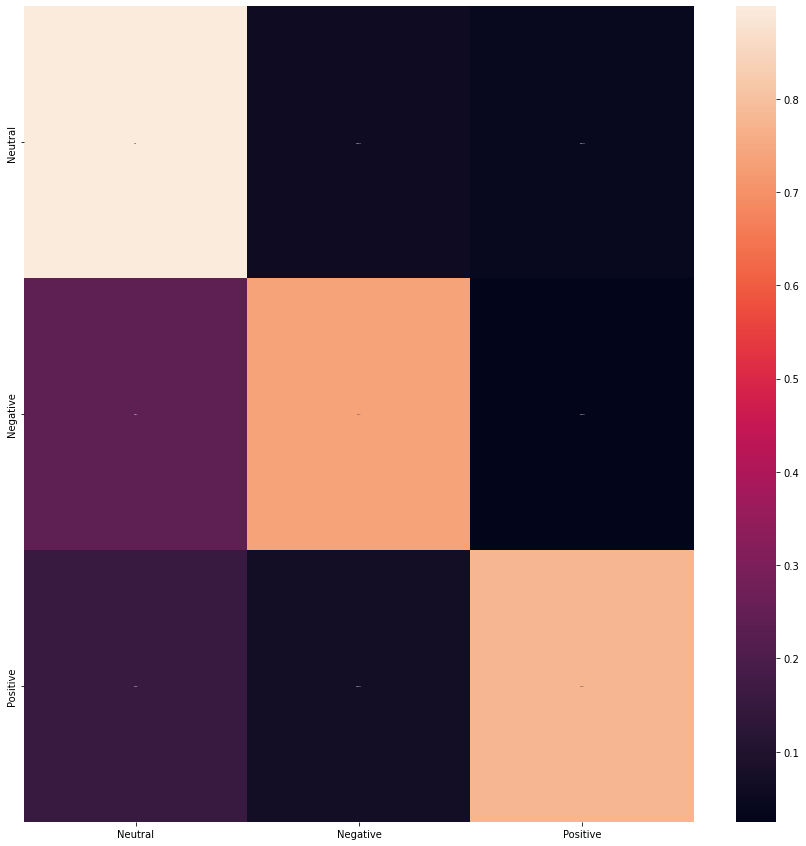

In [33]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 2})

In [1]:
sentiment = ['Neutral','Negative','Positive']

In [2]:
sentiment

['Neutral', 'Negative', 'Positive']

In [3]:
sentiment[2]

'Positive'

In [ ]:
sequence = tokenizer.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]zx

In [ ]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

In [ ]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]xz

# References:

https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91

https://towardsdatascience.com/a-beginners-guide-on-sentiment-analysis-with-rnn-9e100627c02e